##### 1. Import Libraries
In this step, all the important libraries necessary to perform the assignment is imported

In [53]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs

import folium # map rendering library
from bs4 import BeautifulSoup
import lxml
print('Libraries imported.')

Libraries imported.


##### 2. Download Data From Wikipedia
In this step, the data is downloaded and with the help of the beautifulSoup librabry, the data is parsed and stored in a numpy array-looking list

In [61]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

text_result = requests.get(url).text #get the entire html of the article as a str
html_parsed_result = BeautifulSoup(text_result, 'html.parser') #transform the text to html

neighborhood_info_table = html_parsed_result.find('table', class_ = 'wikitable')
neighborhood_rows = neighborhood_info_table.find_all('tr')

# extract the information ('Postal Code', 'Borough', 'Neighbourhood') from the table
neighborhood_info = []
for row in neightborhood_rows:
    info = row.text.split('\n')[1:-1] # remove empty str (first and last items)
    neighborhood_info.append(info)
    
neighborhood_info[0:10]

[['Postal Code', '', 'Borough', '', 'Neighborhood'],
 ['M1A', '', 'Not assigned', '', ''],
 ['M2A', '', 'Not assigned', '', ''],
 ['M3A', '', 'North York', '', 'Parkwoods'],
 ['M4A', '', 'North York', '', 'Victoria Village'],
 ['M5A', '', 'Downtown Toronto', '', 'Regent Park, Harbourfront'],
 ['M6A', '', 'North York', '', 'Lawrence Manor, Lawrence Heights'],
 ['M7A',
  '',
  'Downtown Toronto',
  '',
  "Queen's Park, Ontario Provincial Government"],
 ['M8A', '', 'Not assigned', '', ''],
 ['M9A', '', 'Etobicoke', '', 'Islington Avenue, Humber Valley Village']]

In [63]:
for i in range(len(neighborhood_info)):
        if neighborhood_info[i][4]=='':neighborhood_info[i][4]='Not assigned'
neighborhood_info[0:10]

[['Postal Code', '', 'Borough', '', 'Neighborhood'],
 ['M1A', '', 'Not assigned', '', 'Not assigned'],
 ['M2A', '', 'Not assigned', '', 'Not assigned'],
 ['M3A', '', 'North York', '', 'Parkwoods'],
 ['M4A', '', 'North York', '', 'Victoria Village'],
 ['M5A', '', 'Downtown Toronto', '', 'Regent Park, Harbourfront'],
 ['M6A', '', 'North York', '', 'Lawrence Manor, Lawrence Heights'],
 ['M7A',
  '',
  'Downtown Toronto',
  '',
  "Queen's Park, Ontario Provincial Government"],
 ['M8A', '', 'Not assigned', '', 'Not assigned'],
 ['M9A', '', 'Etobicoke', '', 'Islington Avenue, Humber Valley Village']]

##### 3. Convert to Pandas DF
In this step, the data in the numpy array-looking list is converted to a pandas data frame

In [64]:
neighborhood_info[0][-1] = 'Neighborhood' 
neighborhood_df = pd.DataFrame(neightborhood_info[1:], columns=neightborhood_info[0])

neighborhood_df.head(10)

,Postal Code,,Borough,,Neighborhood
0,M1A,,Not assigned,,Not assigned
1,M2A,,Not assigned,,Not assigned
2,M3A,,North York,,Parkwoods
3,M4A,,North York,,Victoria Village
4,M5A,,Downtown Toronto,,"Regent Park, Harbourfront"
5,M6A,,North York,,"Lawrence Manor, Lawrence Heights"
6,M7A,,Downtown Toronto,,"Queen's Park, Ontario Provincial Government"
7,M8A,,Not assigned,,Not assigned
8,M9A,,Etobicoke,,"Islington Avenue, Humber Valley Village"
9,M1B,,Scarborough,,"Malvern, Rouge"


##### 4. Data Exploration
In this step, the data explored. Som Boroughs have some rows have no assigned Boroughs and/or Neighbohoods

In [65]:
not_assigned_boroughs = neighborhood_df.index[neighborhood_df['Borough'] == 'Not assigned']
not_assigned_neighborhoods = neighborhood_df.index[neighborhood_df['Neighborhood'] == 'Not assigned']
not_assigned_neighborhoods_and_borough = not_assigned_boroughs & not_assigned_neighborhoods

print('The DataFrame shape is {}'.format(neighborhood_df.shape),'\n')
print('There are:')
print('  {} Postal codes'.format(neighborhood_df['Postal Code'].unique().shape[0]))
print('  {} Boroughs'.format(neighborhood_df['Borough'].unique().shape[0] - 1)) # substract one because "not assigned" doesn't count
print('  {} Neighborhoods'.format(neighborhood_df['Neighborhood'].unique().shape[0] - 1)) # substract one because "not assigned" doesn't count
print('  {} rows with Not assigned Borough'.format(not_assigned_boroughs.shape[0]))
print('  {} rows with Nan Neighborhood'.format(not_assigned_neighborhoods.shape[0]))
print('  {} rows with Not assigned Neighborhood and Borough'.format(not_assigned_neighborhoods_and_borough.shape[0]),'\n')

The DataFrame shape is (180, 5) 

There are:
  180 Postal codes
  10 Boroughs
  99 Neighborhoods
  77 rows with Not assigned Borough
  77 rows with Nan Neighborhood
  77 rows with Not assigned Neighborhood and Borough 



In [66]:
# Eliminate the Boroughs that are not assigned
neighborhood_df.drop(neighborhood_df.index[not_assigned_boroughs], inplace=True)
neighborhood_df.reset_index(drop=True, inplace=True)

neighborhood_df.head(10)

,Postal Code,,Borough,,Neighborhood
0,M3A,,North York,,Parkwoods
1,M4A,,North York,,Victoria Village
2,M5A,,Downtown Toronto,,"Regent Park, Harbourfront"
3,M6A,,North York,,"Lawrence Manor, Lawrence Heights"
4,M7A,,Downtown Toronto,,"Queen's Park, Ontario Provincial Government"
5,M9A,,Etobicoke,,"Islington Avenue, Humber Valley Village"
6,M1B,,Scarborough,,"Malvern, Rouge"
7,M3B,,North York,,Don Mills
8,M4B,,East York,,"Parkview Hill, Woodbine Gardens"
9,M5B,,Downtown Toronto,,"Garden District, Ryerson"


In [67]:
# Replace the Not assigned values in neighbohood with the Borough value in the cell
not_assigned_neighborhoods = neighborhood_df.index[neighborhood_df['Neighborhood'] == 'Not assigned'] # run this again because the indexes on the dataframe where reset

for idx in not_assigned_neighborhoods:
    neighborhood_df['Neighborhood'][idx] = neighborhood_df['Borough'][idx]
    
neighborhood_df.head(10)

,Postal Code,,Borough,,Neighborhood
0,M3A,,North York,,Parkwoods
1,M4A,,North York,,Victoria Village
2,M5A,,Downtown Toronto,,"Regent Park, Harbourfront"
3,M6A,,North York,,"Lawrence Manor, Lawrence Heights"
4,M7A,,Downtown Toronto,,"Queen's Park, Ontario Provincial Government"
5,M9A,,Etobicoke,,"Islington Avenue, Humber Valley Village"
6,M1B,,Scarborough,,"Malvern, Rouge"
7,M3B,,North York,,Don Mills
8,M4B,,East York,,"Parkview Hill, Woodbine Gardens"
9,M5B,,Downtown Toronto,,"Garden District, Ryerson"


In [68]:
print('After cleaning the DataFrame, its new shape is {}'.format(neighborhood_df.shape),'\n')
print('There are:')
print('  {} Postal codes'.format(neighborhood_df['Postal Code'].unique().shape[0]))
print('  {} Boroughs'.format(neighborhood_df['Borough'].unique().shape[0]))
print('  {} Neighborhoods'.format(neighborhood_df['Neighborhood'].unique().shape[0]))

After cleaning the DataFrame, its new shape is (103, 5) 

There are:
  103 Postal codes
  10 Boroughs
  99 Neighborhoods


The dataframe has 103 Postal codes and 103 rows. The dataframe is grouped by the Postal code, ending with a dataframe with 103 rows.

In [70]:
group = neighborhood_df.groupby('Postal Code')
grouped_neighborhoods = group['Neighborhood'].apply(lambda x: "%s" % ', '.join(x))
grouped_boroughs = group['Borough'].apply(lambda x: set(x).pop())
grouped_df = pd.DataFrame(list(zip(grouped_boroughs.index, grouped_boroughs, grouped_neighborhoods)))
grouped_df.columns = ['Postal Code', 'Borough', 'Neighborhood']

grouped_df.head(10)

,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park"
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge"
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [79]:
#Get the longitude and latitude of locations
coordinates_df = pd.read_csv('Geospatial_Coordinates.csv') # transform the csv file into a dataframe

print('The coordinates dataframe shape is', coordinates_df.shape)
coordinates_df.head()

The coordinates dataframe shape is (103, 3)


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [112]:
#Add the longitude and Latitude to the Pandas data fra
postcodes_with_coordinates_df = grouped_df.join(coordinates_df.set_index('Postal Code'), on='Postal Code')

postcodes_with_coordinates_df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [113]:
# create map of Toronto using latitude and longitude values
map = folium.Map(location=[43.6532,-79.3832], zoom_start=11)

for location in postcodes_with_coordinates_df.itertuples(): #iterate each row of the dataframe
    label = 'Postal Code: {};  Borough: {};  Neighborhoods: {}'.format(location[1], location[2], location[3])
    label = folium.Popup(label, parse_html=True)    
    folium.CircleMarker(
        [location[-2], location[-1]],
        radius=1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map) 
    folium.Circle(
        radius=500,
        popup=label,
        location=[location[-2], location[-1]],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'
    ).add_to(map) 
    
map

Notice that some of the areas overlap using the 500 meters radius. A different radius for each postcode can result in a more refined and better search for venues, such that misrepresentation of the number of venues in a particular postal code will be avoided.

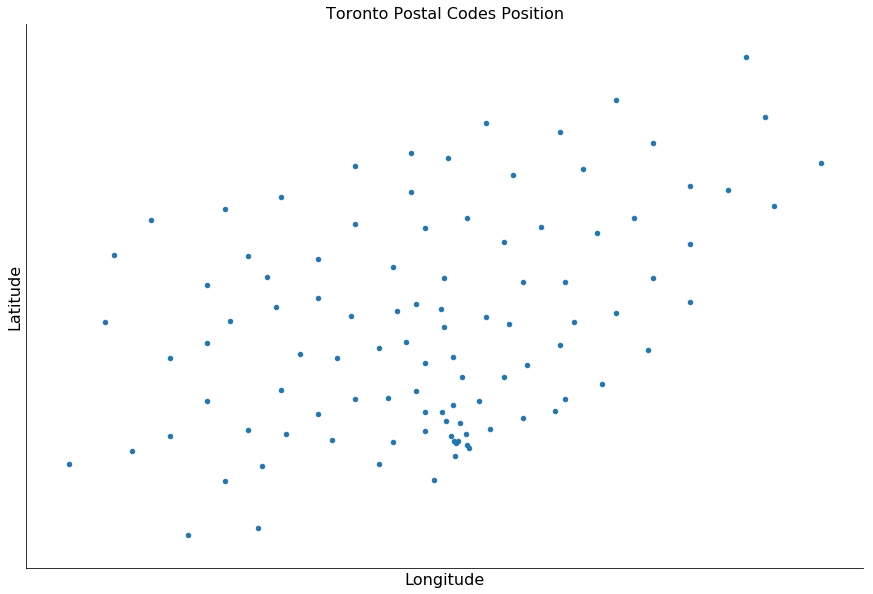

In [114]:
import matplotlib.pyplot as plt

X = postcodes_with_coordinates_df[['Longitude', 'Latitude']]

scatter_plot = X.plot.scatter(x='Longitude', 
               y='Latitude',  
               fontsize = 16,
               figsize=(15, 10))

scatter_plot.set_yticklabels([])
scatter_plot.set_xticklabels([])
scatter_plot.set_xticks([])
scatter_plot.set_yticks([])
scatter_plot.spines['top'].set_color(None)
scatter_plot.spines['right'].set_color(None)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
scatter_plot.set_title('Toronto Postal Codes Position', fontsize=16)

scatter_plot.set_yticklabels(labels = 'Latitude', fontdict={'fontsize': 20})
plt.show()

To define the radius to use with the foursquare, it is important to find the closest points for each postal code.

In [116]:
from geopy.distance import great_circle

#function to get the closest postcode pair and the distance using latitude and longitude
def closest_postcode(postcode, postcodes):
    postcode = np.asarray(postcode).reshape(1,-1)
    postcodes = np.asarray(postcodes)
    distances = [great_circle(postcode, point).meters for point in postcodes]
    closest_postcode_index = np.argmin(distances)
    return [round(distances[closest_postcode_index]), closest_postcode_index]

In [117]:
#To explore the distance function, the closest postcode to the first example in the dataframe is found
coordinates = postcodes_with_coordinates_df[['Latitude', 'Longitude']]

distance, closest_point_index = closest_postcode(coordinates[:1], coordinates[~coordinates.index.isin([0])])
close_points = X[:1].append(X[closest_point_index+1:closest_point_index+2])
close_points

,Longitude,Latitude
0,-79.194353,43.806686
16,-79.205636,43.836125


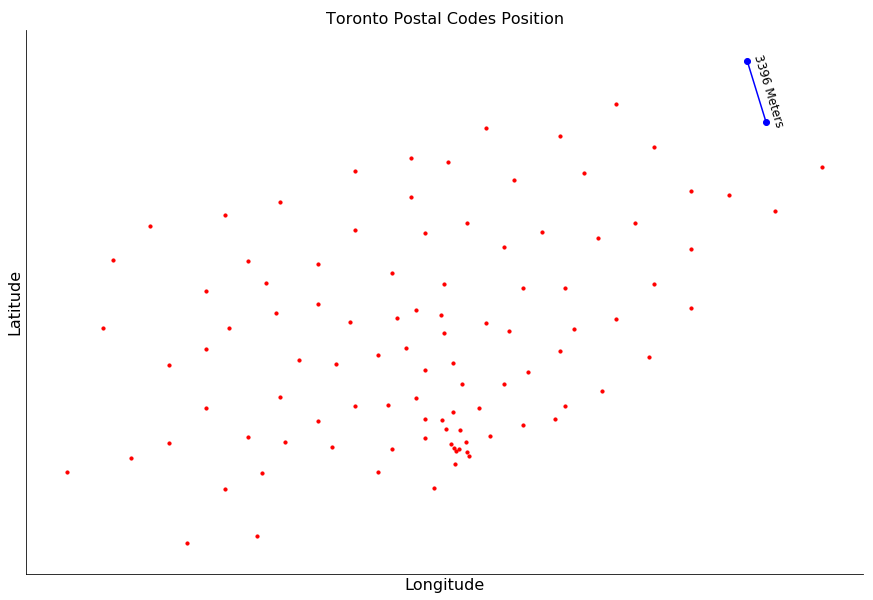

In [118]:
fig = plt.figure(figsize=(15,10))
scatter_plot = fig.add_subplot(111)
scatter_plot.scatter(X['Longitude'],X['Latitude'], s=10, c='r', marker="o")
scatter_plot.plot(close_points['Longitude'], close_points['Latitude'], c='b', marker="o")

# plt.legend(loc='upper left');
scatter_plot.annotate('{} Meters'.format(distance),
            xy=(.859, .912), xycoords='figure fraction',
            ha='left', va='top', rotation=-73,
            fontsize=12)

scatter_plot.set_yticklabels([])
scatter_plot.set_xticklabels([])
scatter_plot.set_xticks([])
scatter_plot.set_yticks([])
scatter_plot.spines['top'].set_color(None)
scatter_plot.spines['right'].set_color(None)

plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title('Toronto Postal Codes Position', fontsize=16)

scatter_plot.set_yticklabels(labels = 'Latitude', fontdict={'fontsize': 20})
plt.show()

In [120]:
#Radius cover for each postal code is added
from math import isnan

for lat, lng, idx in zip(postcodes_with_coordinates_df['Latitude'], postcodes_with_coordinates_df['Longitude'], postcodes_with_coordinates_df.index):
    distance, closest_point_index = closest_postcode([lat,lng], coordinates[~coordinates.index.isin([idx])])
    postcodes_with_coordinates_df.at[idx,'Distance'] = np.int64(distance//2) #use the half of the disstance to avoid overlapping
    
postcodes_with_coordinates_df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Distance
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,1698.0
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,1625.0
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1205.0
3,M1G,Scarborough,Woburn,43.770992,-79.216917,913.0
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,913.0


In [121]:
map = folium.Map(location=[43.6532,-79.3832], zoom_start=11)

for location in postcodes_with_coordinates_df.itertuples(): #iterate each row of the dataframe
    label = 'Postal Code: {};  Borough: {};  Neighborhoods: {}'.format(location[1], location[2], location[3])
    label = folium.Popup(label, parse_html=True)    
    folium.CircleMarker(
        [location[-3], location[-2]],
        radius=1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map) 
    folium.Circle(
        radius=location[-1],
        popup=label,
        location=[location[-3], location[-2]],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'
    ).add_to(map) 
    
map

###### Step 5 (Segmentation)
Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

In [123]:
CLIENT_ID = 'OVRXU0L3BTQWDGLVIFS1LQZONX0YUIDMBR1QUKZIYVILNAII'
CLIENT_SECRET = '0TD3IABDCRIQ0AANXYQJB0AYFWSKPHP15HR41O2LMLOUXLY4' 
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: OVRXU0L3BTQWDGLVIFS1LQZONX0YUIDMBR1QUKZIYVILNAII
CLIENT_SECRET:0TD3IABDCRIQ0AANXYQJB0AYFWSKPHP15HR41O2LMLOUXLY4


In [146]:
#To explore the data returned by the Foursquare API, a maximum of 100 venues from the first postcode are requested in a radius of 500 meters
#function to format url
def format_url(lat, lng, radius=500, limit=100):
    return 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, 
        lat, lng, VERSION, radius, limit)

In [147]:
first_postcode = postcodes_with_coordinates_df.iloc[2, :]
url = format_url(first_postcode['Latitude'], first_postcode['Longitude'], first_postcode['Distance'])

url

'https://api.foursquare.com/v2/venues/explore?client_id=OVRXU0L3BTQWDGLVIFS1LQZONX0YUIDMBR1QUKZIYVILNAII&client_secret=0TD3IABDCRIQ0AANXYQJB0AYFWSKPHP15HR41O2LMLOUXLY4&ll=43.7635726,-79.1887115&v=20180605&radius=1205.0&limit=100'

In [148]:
#function to get batch of venues as a dataframe
def get_venues(url):
    results = requests.get(url).json()
    venues = results['response']['groups'][0]['items']
    return json_normalize(venues)

venues_df = get_venues(url)
venues_df.head()

,reasons.count,reasons.items,referralId,venue.categories,venue.id,venue.location.address,venue.location.cc,venue.location.city,venue.location.country,venue.location.crossStreet,venue.location.distance,venue.location.formattedAddress,venue.location.labeledLatLngs,venue.location.lat,venue.location.lng,venue.location.postalCode,venue.location.state,venue.name,venue.photos.count,venue.photos.groups
0,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4bc366dab492d13a51b2a860-0,"[{'id': '4d4ae6fc7a7b7dea34424761', 'name': 'F...",4bc366dab492d13a51b2a860,4449 Kingston Road,CA,Scarborough,Canada,at Lawrence and Morningside,579,[4449 Kingston Road (at Lawrence and Morningsi...,"[{'label': 'display', 'lat': 43.76875171771289...",43.768752,-79.187982,M1E 2N7,ON,Chick-N-Joy,0,[]
1,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4b3a9504f964a520646a25e3-1,"[{'id': '4bf58dd8d48988d186941735', 'name': 'L...",4b3a9504f964a520646a25e3,4525 Kingston Rd.,CA,Toronto,Canada,at Lawrence Ave. E,944,"[4525 Kingston Rd. (at Lawrence Ave. E), Toron...","[{'label': 'display', 'lat': 43.77146181777272...",43.771462,-79.184384,M1E 2P1,ON,LCBO,0,[]
2,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4ba164fdf964a52039b337e3-2,"[{'id': '4bf58dd8d48988d1f9941735', 'name': 'F...",4ba164fdf964a52039b337e3,4525 Kingston Rd,CA,West Hill,Canada,Morningside Crossing,933,"[4525 Kingston Rd (Morningside Crossing), West...","[{'label': 'display', 'lat': 43.77134173380578...",43.771342,-79.184341,NaN,ON,Bulk Barn,0,[]
3,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4c9fdb04542b224bca4201a0-3,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",4c9fdb04542b224bca4201a0,4218 Lawrence Avenue East,CA,Scarborough,Canada,NaN,701,"[4218 Lawrence Avenue East, Scarborough ON M1E...","[{'label': 'display', 'lat': 43.76904597684398...",43.769046,-79.184386,M1E 4X9,ON,Little Caesars Pizza,0,[]
4,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4beca2f9d6e676b0538764d4-4,"[{'id': '52f2ab2ebcbc57f1066b8b41', 'name': 'S...",4beca2f9d6e676b0538764d4,"4525 Kingston Road, Unit #H8",CA,Scarborough,Canada,at Collinsgrove Rd.,870,"[4525 Kingston Road, Unit #H8 (at Collinsgrove...","[{'label': 'display', 'lat': 43.77066813, 'lng...",43.770668,-79.184150,M1E 2P1,ON,Booster Juice,0,[]


In this case, the relevant information is venue.categories, venue.location.lat, venue.location.lng and venue.name

In [149]:

#function to clean the venues dataframe
def clean_df(df):
    relevant_columns = ['venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.name']
    clean_df = df.loc[:,relevant_columns]

    #rename columns
    clean_df.columns = ['Category', 'Lat', 'Lng', 'Name']
    return clean_df 

venues_df = clean_df(venues_df)
venues_df.head()

,Category,Lat,Lng,Name
0,"[{'id': '4d4ae6fc7a7b7dea34424761', 'name': 'F...",43.768752,-79.187982,Chick-N-Joy
1,"[{'id': '4bf58dd8d48988d186941735', 'name': 'L...",43.771462,-79.184384,LCBO
2,"[{'id': '4bf58dd8d48988d1f9941735', 'name': 'F...",43.771342,-79.184341,Bulk Barn
3,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",43.769046,-79.184386,Little Caesars Pizza
4,"[{'id': '52f2ab2ebcbc57f1066b8b41', 'name': 'S...",43.770668,-79.184150,Booster Juice


In [150]:
venues_df.loc[0, 'Category']

[{'id': '4d4ae6fc7a7b7dea34424761',
  'name': 'Fried Chicken Joint',
  'pluralName': 'Fried Chicken Joints',
  'shortName': 'Fried Chicken',
  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/friedchicken_',
   'suffix': '.png'},
  'primary': True}]

In [151]:
#function that extract the category name
def get_category_name(row):
    category_json = row['Category']
    try:
        return category_json[0]['name']
    except:        
        return None

venues_df['Category'] = venues_df.apply(get_category_name, axis=1)

venues_df

,Category,Lat,Lng,Name
0,Fried Chicken Joint,43.768752,-79.187982,Chick-N-Joy
1,Liquor Store,43.771462,-79.184384,LCBO
2,Food & Drink Shop,43.771342,-79.184341,Bulk Barn
3,Pizza Place,43.769046,-79.184386,Little Caesars Pizza
4,Smoothie Shop,43.770668,-79.184150,Booster Juice
5,Restaurant,43.768122,-79.190493,Swiss Chalet
6,Breakfast Spot,43.772319,-79.184900,Sunset Grill
7,Bank,43.766790,-79.191151,RBC Royal Bank
8,Pharmacy,43.770282,-79.185012,Shoppers Drug Mart
9,Beer Store,43.769793,-79.187505,The Beer Store


In [158]:
#function to construct the dataframe with all the venues (max 100 venues per postal code)
def get_all_venues(postcodes, lat, lng, radius):
    venues_list=[]
    for postcode, lat, lng, radius in zip(postcodes, lat, lng, radius):
        url= format_url(lat, lng, radius)
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        venues_list.append([(
            postcode, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'], 
            v['venue']['categories'][0]['name'])
            for v in results])
    all_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    all_venues.columns = ['Postal Code', 
                  'Postcode Latitude', 
                  'Postcode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category'
                  ]
    
    return all_venues

In [159]:
all_venues = get_all_venues(postcodes_with_coordinates_df['Postal Code'], postcodes_with_coordinates_df['Latitude'], postcodes_with_coordinates_df['Longitude'], postcodes_with_coordinates_df['Distance'])

print('The total number of venues returned is ', all_venues.shape[0])

all_venues.head()

The total number of venues returned is  3336


,Postal Code,Postcode Latitude,Postcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M1B,43.806686,-79.194353,African Rainforest Pavilion,43.817725,-79.183433,Zoo Exhibit
1,M1B,43.806686,-79.194353,Penguin Exhibit,43.819435,-79.185959,Zoo Exhibit
2,M1B,43.806686,-79.194353,Orangutan Exhibit,43.818413,-79.182548,Zoo Exhibit
3,M1B,43.806686,-79.194353,Harvey's,43.800020,-79.198307,Restaurant
4,M1B,43.806686,-79.194353,Gorilla Exhibit,43.819080,-79.184235,Zoo Exhibit


In [161]:
print('Total Toronto postcodes:', postcodes_with_coordinates_df['Postal Code'].shape[0])
print('Total Toronto postcodes with venues:', all_venues['Postal Code'].unique().shape[0])

Total Toronto postcodes: 103
Total Toronto postcodes with venues: 102


Thismeans that there is one postal code with no venues returned from the Foursquare API. This is below

In [162]:
postcodes_diff = np.setdiff1d(postcodes_with_coordinates_df['Postal Code'].values,all_venues['Postal Code'].unique())
postcodes_with_coordinates_df[postcodes_with_coordinates_df['Postal Code']==postcodes_diff[0]]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Distance
56,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,111.0


###### Step 6 (Analyze Venue Data)
In this step, the venues data returned by Fourequare API is analyzed to get a better sense of the best way of clustering the postalcodes

In [164]:
venues_in_postcode = all_venues.groupby('Postal Code').count()
venues_in_postcode = pd.DataFrame(list(zip(venues_in_postcode.index, venues_in_postcode['Venue'])), 
                                  columns=['Postal Code', '# of Venues']).set_index('Postal Code').join(postcodes_with_coordinates_df[['Postal Code','Distance']].set_index('Postal Code'), on='Postal Code').reset_index()
venues_in_postcode['Distance'] = np.int64(venues_in_postcode['Distance'])
venues_in_postcode.loc[len(venues_in_postcode.index)] = ['M5E', 0, 111] #add M5E (postcode without venues) with zero as # of venues

venues_in_postcode.head()

,Postal Code,# of Venues,Distance
0,M1B,41,1698
1,M1C,13,1625
2,M1E,30,1205
3,M1G,5,913
4,M1H,21,913


In [165]:
venues_in_postcode[['# of Venues']].describe()

,# of Venues
count,103.00000
mean,32.38835
std,24.73833
min,0.00000
25%,13.00000
50%,28.00000
75%,44.50000
max,100.00000


The minimum amount of venues present on a postcode is 0, as we add M5E, and the maximum is 100, expected given the limit of venues set on the request sent to the Foursquare API. 50% of the venues presents 26 or less venues.
The venues Frequency Distribution of the number of venues is presented next

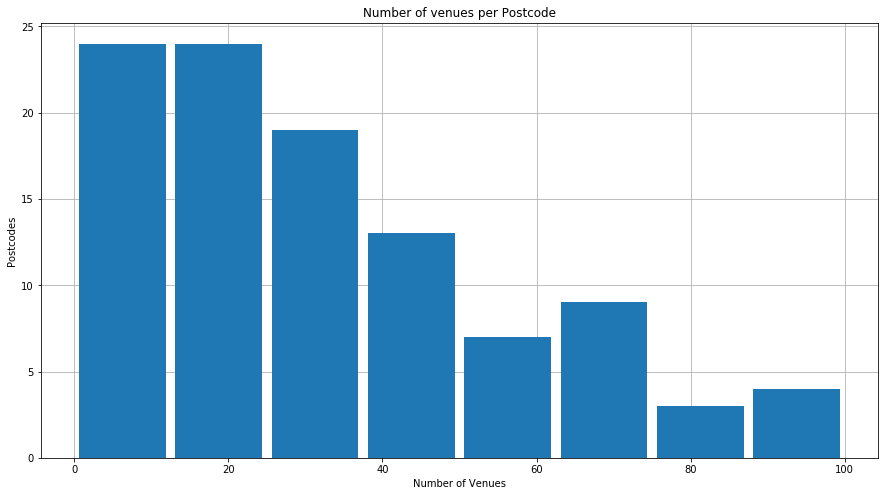

In [166]:
venues_in_postcode['# of Venues'].hist(bins=8, figsize=(15,8),zorder=2, rwidth=0.9)

plt.xlabel('Number of Venues')
plt.ylabel('Postcodes')
plt.title('Number of venues per Postcode')
plt.show()

Given that each postcode has a different radius passed to the venues request, it's better to represent the venues per postcode in terms of density, that's venues per are cover for each postcode, in this case the area cover in the venues search defined by the distance to the closest postcode

In [169]:
density_venues_in_postcode = all_venues.groupby('Postal Code').count()

density_venues_in_postcode = pd.DataFrame(list(zip(density_venues_in_postcode.index, density_venues_in_postcode['Venue'])), 
                                  columns=['Postal Code', 'Density']).set_index('Postal Code').join(postcodes_with_coordinates_df[['Postal Code','Distance']].set_index('Postal Code'), on='Postal Code').reset_index()
density_venues_in_postcode['Density'] = np.int64(density_venues_in_postcode['Density']/(density_venues_in_postcode['Distance']/1000)) #distance in km
density_venues_in_postcode.loc[len(venues_in_postcode.index)] = ['M5E', 0, 111] #add M5E (postcode without venues) with zero as density

density_venues_in_postcode.head()

,Postal Code,Density,Distance
0,M1B,24,1698.0
1,M1C,8,1625.0
2,M1E,24,1205.0
3,M1G,5,913.0
4,M1H,23,913.0


In [170]:
density_venues_in_postcode[['Density']].describe()

,Density
count,103.000000
mean,45.495146
std,46.114919
min,0.000000
25%,15.500000
50%,31.000000
75%,58.000000
max,274.000000


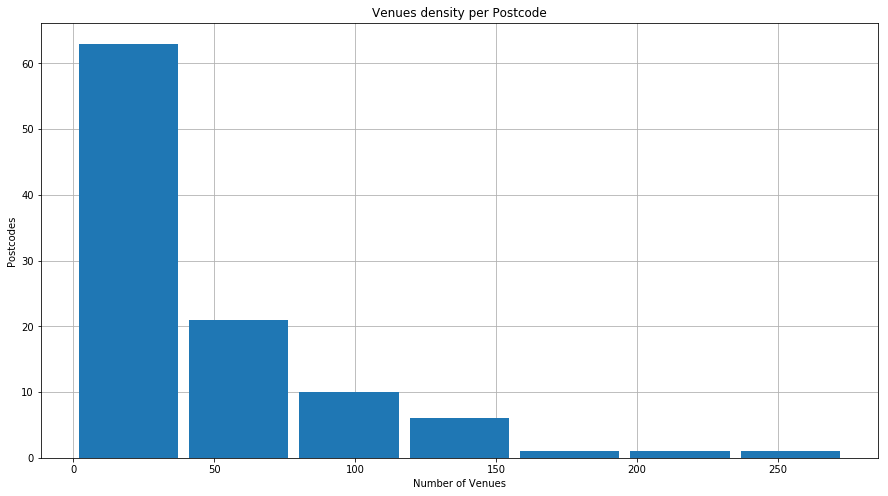

In [171]:
density_venues_in_postcode['Density'].hist(bins=7, figsize=(15,8),zorder=2, rwidth=0.9)

plt.xlabel('Number of Venues')
plt.ylabel('Postcodes')
plt.title('Venues density per Postcode')
plt.show()

THe histogram shows that 60% of the postcodes presents a density between 0 and 30 venues per area (expressed as radius). That is expected given that Toronto has a low population density. The last three bars on the plot have very low values, it could be possible to merge that data and use 5 venues density ranges for the clustering

##### Step 7 Clustering
Next the postal codes are clustered based on venues density. One important parameter is the number of clusters and based on previous analysis a tentative value is five clusters. Next the elbow method is used to have a better sense of the optimal number.

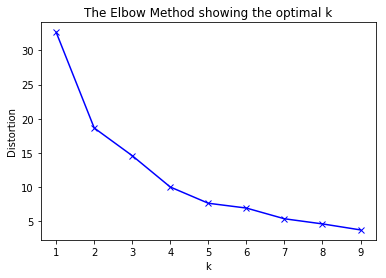

In [172]:

from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
K = range(1,10)
for k in K:
    k_means = KMeans(init = "k-means++", n_clusters = k, n_init = 12)
    k_means.fit(density_venues_in_postcode['Density'].values.reshape(-1, 1))
    distortions.append(sum(np.min(cdist(density_venues_in_postcode['Density'].values.reshape(-1, 1),
                                        k_means.cluster_centers_, 'euclidean'), axis=1)) / density_venues_in_postcode['Density'].shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [173]:
num_clusters = 5

k_means = KMeans(init = "k-means++", n_clusters = num_clusters, n_init = 12)
k_means.fit(density_venues_in_postcode['Density'].values.reshape(-1, 1))
labels = k_means.labels_

print(labels)

[2 2 2 2 2 2 0 0 2 2 0 0 0 0 0 0 2 2 0 2 2 0 4 0 2 0 2 0 0 0 2 2 2 2 2 2 2
 4 4 0 0 3 0 3 2 2 0 4 2 4 2 4 1 4 1 0 4 3 1 4 3 0 2 2 0 4 3 0 4 3 0 0 2 2
 0 0 3 4 2 2 0 4 4 4 2 0 0 2 0 0 2 0 2 2 2 2 2 2 2 2 2 2 2]


In [175]:
density_venues_in_postcode['Cluster'] = k_means.labels_
density_venues_in_postcode.head()

,Postal Code,Density,Distance,Cluster
0,M1B,24,1698.0,2
1,M1C,8,1625.0,2
2,M1E,24,1205.0,2
3,M1G,5,913.0,2
4,M1H,23,913.0,2


##### Step 8 Cluster Examination

In [179]:
centroids = np.int64(round(density_venues_in_postcode.groupby('Cluster').mean()['Density']))
frecuency = density_venues_in_postcode.groupby('Cluster').count()['Postal Code']

cluster_info = pd.DataFrame([np.arange(0,5), centroids, frecuency], index=['Cluster', 'Centroid','Postal Codes']).T
cluster_info.sort_values('Centroid', inplace=True)
cluster_info.reset_index(drop=True, inplace=True)

cluster_info

,Cluster,Centroid,Postal Codes
0,2,13,45
1,0,40,33
2,4,82,15
3,3,124,7
4,1,224,3


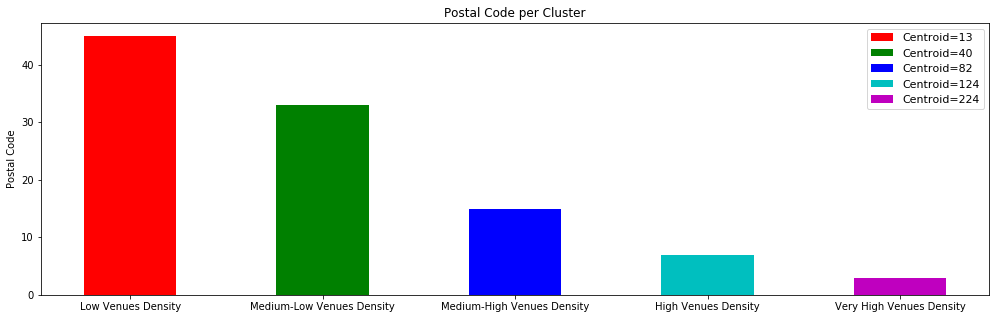

In [181]:
fig, ax = plt.subplots(figsize=(17,5))
clusters= ['Low Venues Density','Medium-Low Venues Density','Medium-High Venues Density','High Venues Density','Very High Venues Density']
colors = ['r','g','b','c','m']
legend = []

for id, cluster in enumerate(clusters):
    legend.append('Centroid={}'.format(cluster_info['Centroid'][id]))
    bar = ax.bar(cluster, cluster_info['Postal Codes'][id], 0.48, color=colors[id])

ax.set_ylabel('Postal Code')
ax.set_title('Postal Code per Cluster')
# ax.set_facecolor((1,1,1))
# ax.grid(True, axis='y',color='k', linestyle='-', linewidth=1)

plt.legend(legend, fontsize=11)

plt.show()


In [182]:
postcodes_with_coordinates_df = pd.concat([postcodes_with_coordinates_df[:56],postcodes_with_coordinates_df[57:],postcodes_with_coordinates_df[56:57]]) #move M5E to the last row
postcodes_with_coordinates_df['Cluster'] = k_means.labels_

colors = ['red','green','blue','cyan','magenta']
clusters_values = cluster_info['Cluster']

map = folium.Map(location=[43.6532,-79.3832], zoom_start=11)

for location in postcodes_with_coordinates_df.itertuples(): #iterate each row of the dataframe
    cluster_index = clusters_values.index[clusters_values==location[-1]][0]
    label = 'Postal Code: {};  Borough: {};  Neighborhoods: {}; {}'.format(location[1], location[2], location[3], clusters[cluster_index])
    label = folium.Popup(label, parse_html=True)    
    folium.Circle(
        radius=location[-2],
        popup=label,
        location=[location[-4], location[-3]],
        color=None,
        fill=True,
        fill_opacity=0.4,
        fill_color=colors[cluster_index]
    ).add_to(map) 

map